In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(69)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.vgg16 import VGG16
from keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
folder_benign_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/benign'
folder_malignant_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant'

folder_benign_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign'
folder_malignant_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

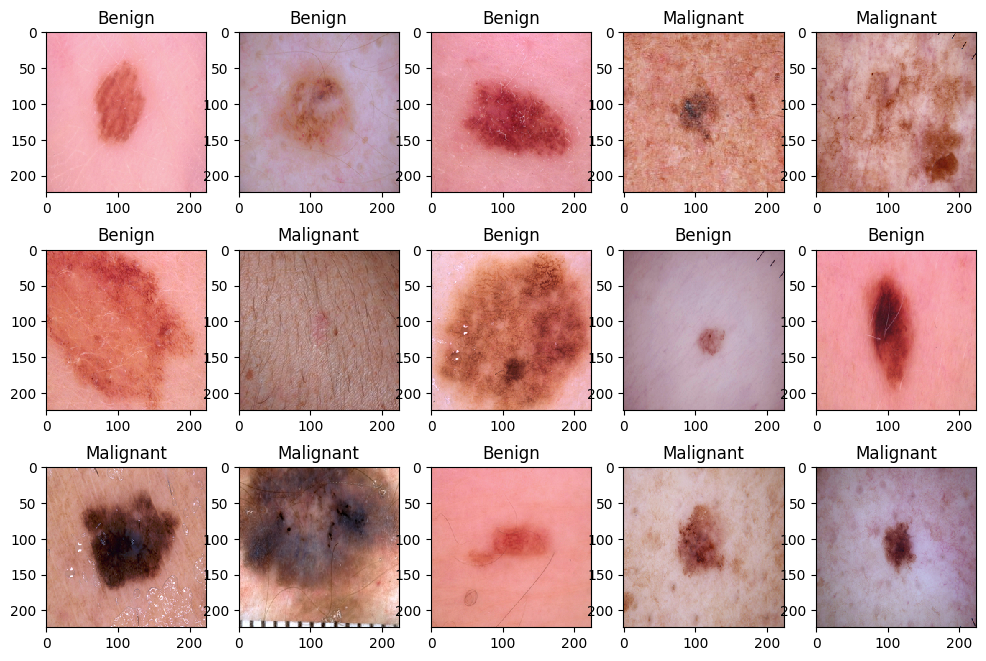

In [3]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [4]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [5]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

Epoch 1/50
33/33 - 16s - loss: 0.6887 - accuracy: 0.5505 - val_loss: 0.6866 - val_accuracy: 0.5284 - lr: 1.0000e-05 - 16s/epoch - 497ms/step
Epoch 2/50
33/33 - 14s - loss: 0.6646 - accuracy: 0.5505 - val_loss: 0.6281 - val_accuracy: 0.5284 - lr: 1.0000e-05 - 14s/epoch - 435ms/step
Epoch 3/50
33/33 - 15s - loss: 0.5825 - accuracy: 0.6842 - val_loss: 0.5254 - val_accuracy: 0.7367 - lr: 1.0000e-05 - 15s/epoch - 440ms/step
Epoch 4/50
33/33 - 14s - loss: 0.5318 - accuracy: 0.7378 - val_loss: 0.4932 - val_accuracy: 0.7519 - lr: 1.0000e-05 - 14s/epoch - 434ms/step
Epoch 5/50
33/33 - 14s - loss: 0.5082 - accuracy: 0.7449 - val_loss: 0.4936 - val_accuracy: 0.7727 - lr: 1.0000e-05 - 14s/epoch - 434ms/step
Epoch 6/50
33/33 - 14s - loss: 0.4517 - accuracy: 0.7824 - val_loss: 0.4331 - val_accuracy: 0.7936 - lr: 1.0000e-05 - 14s/epoch - 434ms/step
Epoch 7/50
33/33 - 15s - loss: 0.4530 - accuracy: 0.7800 - val_loss: 0.4231 - val_accuracy: 0.7955 - lr: 1.0000e-05 - 15s/epoch - 440ms/step
Epoch 8/50
33

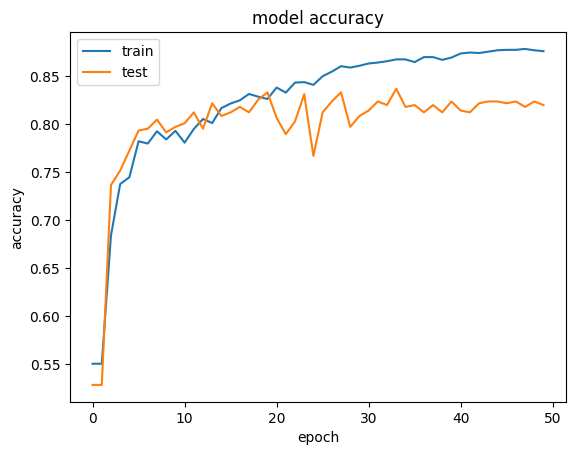

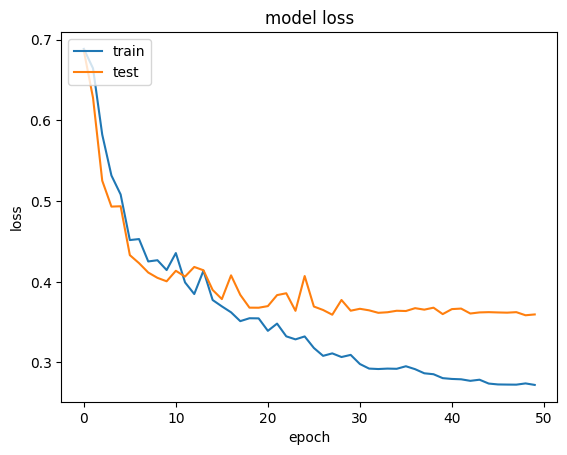

In [7]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = VGG16(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()